<a href="https://colab.research.google.com/github/brianod/deeplearning-pneumonia-xray/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preface**

I am using the chest x-ray dataset here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

I have placed it in the root of my Google Drive which is where this notebook on Colaboratory will access it from.

On Google Colaboratory, sure you select Runtime -> Change Runtime Type -> GPU before running the notebook.

**Setup**

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 61kB 4.3MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 1.0MB 8.4MB/s 
     |████████████████████████████████| 358kB 12.7MB/s 
     |████████████████████████████████| 40kB 6.5MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 2.7MB 18.9MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
·········

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

**Set the path of the chest_xray folder in Google Drive**

In [ ]:
xray_path = Path.joinpath(gdrive, 'chest_xray')
xray_path.is_dir()

True

**Verify the chest_xray image files are valid images**

In [ ]:
fns = get_image_files(xray_path)
fns

(#5856) [Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'),Path('/content/gdrive/My Drive/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

**Specify folders containing training, validation, and test sets**

In [ ]:
custom_splitter = GrandparentSplitter(train_name=('train', 'val'), valid_name='test')

**Create a DataBlock and DataLoaders**

A DataBlock is the transformed data, and a DataLoader in PyTorch is an abstraction that makes it easier to iterate over data using parameters such as batch size.

In [ ]:
xrays = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=custom_splitter,
    get_y=parent_label,
    item_tfms=Resize(256))

In [ ]:
dls = xrays.dataloaders(xray_path)

**Show 4 chest x-rays from the validation set.**

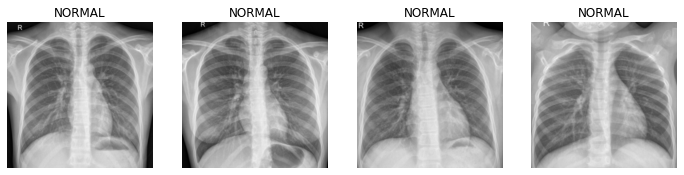

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

**Randomly crop to different areas of the xray**

More data augmentation. The following are the same xray shown with 4 different crops.

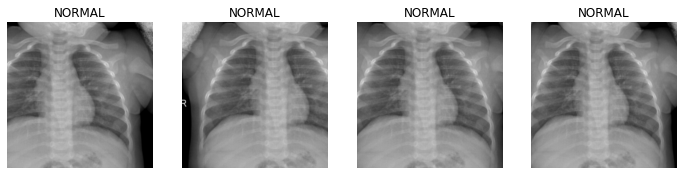

In [ ]:
xrays = xrays.new(item_tfms=RandomResizedCrop(256, min_scale=0.7))
dls = xrays.dataloaders(xray_path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

**Use resnet50 pre-trained model and find the optimal learning rate**

The optimal learning rate is an order of magnitude less than the lowest point of the loss.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0006918309954926372)

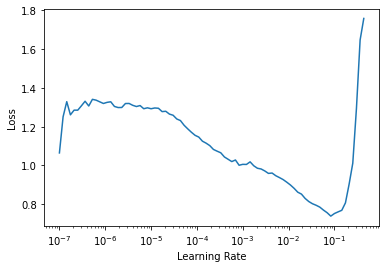

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.lr_find()

**Fine tune the pretrained model by training the last layers for 4 epochs**

Transfer learning. 4 epochs was an arbitrary choice. 

`fine_tune` freezes the well-trained first layers, trains for `freeze_epochs=1` epochs, then unfreezes and trains all layers for 4 (argument supplied) epochs.

In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.454557,0.718677,0.198718,01:43


epoch,train_loss,valid_loss,error_rate,time
0,0.188958,1.042401,0.245192,01:51
1,0.119776,0.607215,0.217949,01:50
2,0.078995,0.627241,0.187500,01:49
3,0.053839,0.376141,0.121795,01:50


Unfreeze all layers and train for 12 epochs using the learning rate we found with `lr_find`

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.114177,0.451784,0.123397,01:50
1,0.142159,1.167055,0.203526,01:49
2,0.205139,0.360007,0.120192,01:50
3,0.158097,0.312015,0.070513,01:50
4,0.115267,0.336613,0.105769,01:50
5,0.112579,1.180396,0.224359,01:49
6,0.097856,0.354895,0.105769,01:48
7,0.064272,0.735087,0.166667,01:48
8,0.050575,0.693501,0.149038,01:47
9,0.033466,0.634683,0.129808,01:48


**~88% accuracy!**

Plot the confusion matrix. It seems the model's errors are almost always false positives rather than false negatives. That is, it predicts someone has Pneumonia when they don't, but rarely predicts that someone who does have Pneuomonia doesn't have Pneumonia. False positives are better than false negatives in this case, at least virtually no one with pneumonia is denied treatment.

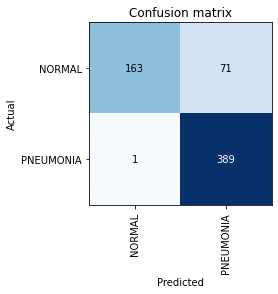

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's plot images the model got wrong.

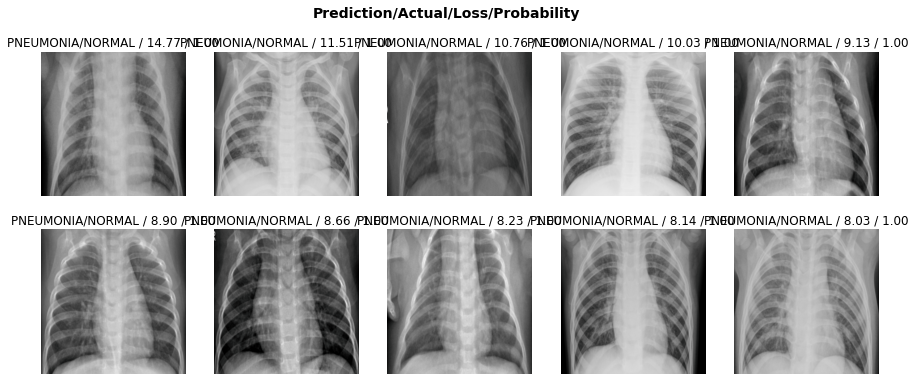

In [ ]:
interp.plot_top_losses(10, nrows=2)